# Ec 143 - Problem Set 1
# Duration analysis and criminal recidivism
Due by 5PM on February 9th. The GSI, Nadav Tadelis (ntadelis@berkeley.edu), will handle the logistics of problem set collection.    

Working with your classmates on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials.    

This problem set reviews the material on discrete hazard analysis developed in lecture.

In [1]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2023/Datasets/'
graphics = '/Users/bgraham/Dropbox/Teaching/Berkeley_Courses/Ec143/Ec143_Spring2023/Graphics/'

## Load and organize dataset

This problem set uses deidentified data from the State of Iowa to study post-release recidivism among formally incarcerated individuals. The dataset includes information on 5,192 individuals who were released from prison in the 2019 fiscal year. These data are publicly available online [here](https://data.iowa.gov/Correctional-System/Iowa-Prison-Recidivism-Status-Current-Cohort/msmx-x2q6) (downloaded on 18 Jan 2023). Information about the dataset, including variable definitions, can be found on the webpage linked to above. An overview of recidivism patterns nationwide, undertaken by the U.S. Department of Justice, Bureau of Justice Statistics, can be found online [here](https://bjs.ojp.gov/BJS_PUB/rpr24s0810yfup0818/Web%20content/508%20compliant%20PDFs).

The next block of code loads the raw data into a pandas dataframe and prints out the first five records.

In [3]:
iowa = pd.read_csv (data + 'Iowa_Prison_Recidivism_Status__Current_Cohort.csv')
iowa[0:5]

,Race,Sex,Age,Supervising Unit,Supervision Type,Cohort Fiscal Year,Report Fiscal Year,Supervision Start Date,Supervision End Date,Months Supervised,...,Supervision Offense Subtype,Reincarcerated,Reincarcerated Reason,Survival Time (Days),Survival Time (Months),Reincarcerated Offense Code,Reincarcerated Offense Class,Reincarcerated Offense Type,Reincarcerated Offense Subtype,Risk Ranking
0,White,Male,39,Newton Correctional Facility,Prison,2019,2022,05/19/2014,07/08/2018,49,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,White,Male,59,Districts/Compact Regions,Work Release,2019,2022,03/22/2018,07/19/2018,3,...,Trafficking,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
2,White,Female,40,Districts/Compact Regions,Work Release,2019,2022,10/12/2018,11/20/2018,1,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
3,White,Male,53,Iowa Medical & Classification Center,Prison,2019,2022,09/08/2017,10/18/2018,13,...,Assault,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
4,White,Male,53,Fort Dodge Correctional Facility,Prison,2019,2022,10/04/2018,05/08/2019,7,...,Drug Possession,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate


The variable **Supervision End Reason** records the reason for the individual's release from prison. We will focus on the subset of individuals who were either discharged at the end of their sentences, paroled, or paroled with immediate discharge. We will further limit ourselves to biologically male individuals. These criteria result in an estimation sample which includes 3,939 individuals who were released from prison in fiscal year 2019 (i.e., between July 1st, 2018 and June 30th 2019)

The outcome/duration of interest is the number of months until re-incarceration. Individuals are followed for up to three years post-release. If they are not re-incarcerated after three years, then the **Survival Time (Months)** variable is censored and coded as missing. We will also extract the variable **Risk Ranking**. This variable, determined prior to release, codes individuals as having a 'Low', 'Moderate' or 'High' risk of re-offending.

In [4]:
sample = iowa[['Survival Time (Months)','Risk Ranking']].loc[iowa['Supervision End Reason'].isin(['Discharged - Expiration of Sentence', 'Parole Granted', 'Paroled w/Immediate Discharge']) & (iowa['Sex'] == 'Male')]
sample.describe()

,Survival Time (Months)
count,1542.000000
mean,13.426200
std,9.176405
min,0.100000
25%,6.200000
50%,11.050000
75%,18.575000
max,36.500000


Next we create an indicator (**D**) for whether the observed spell is complete (**D = 1**) or censored (**D = 0**). We also create an observed duration (**Z**) variable. Both these variables are as described in class. We also round up the recorded duration time to the nearest integer. Hence an individual who is re-incarcerated after 0.4 months is assigned a **Z** value of 1, indicating that they were re-incarcerated in their first month post-release. In this dataset all censoring is due to the end of follow-up after 36 months, evidently no individuals are lost to follow-up prior to this time (this is so called fixed right censoring). This means that the observed duration for any censored individual is set equal to 37 months. All we know about these individuals is that they were re-incarcerated no sooner than 37 months post release.

In [8]:
sample['D'] = sample[['Survival Time (Months)']].notnull()
sample['Z'] = sample[['Survival Time (Months)']].apply(np.ceil)
sample['Z'].fillna(37, inplace = True)
sample['Z'] = sample['Z'].astype(int)
sample[['Z','D']].describe()

,Z
count,3939.000000
mean,27.943894
std,12.668515
min,1.000000
25%,15.000000
50%,37.000000
75%,37.000000
max,37.000000


## Kaplan-Meier survival function estimation

This next block of code takes the raw data and constructs a `life table' as described in class.

In [9]:
grp = sample.groupby('Z')
lifetable = pd.DataFrame({"N_z": grp.size(), "Re-incarcerated": grp["D"].sum()})

N = len(sample)
prior_count = lifetable["N_z"].cumsum().shift(1, fill_value=0)
lifetable.insert(0, "At risk", N - prior_count)

lifetable["Censored"] = (lifetable["At risk"] - lifetable["At risk"].shift(-1, fill_value=0) - lifetable["Re-incarcerated"])

lifetable.drop(['N_z'], axis=1, inplace = True)

lifetable

,At risk,Re-incarcerated,Censored
Z,,,
1,3939,17,0
2,3922,36,0
3,3886,61,0
4,3825,85,0
5,3740,74,0
6,3666,102,0
7,3564,72,0
8,3492,102,0
9,3390,84,0


**Question 1**: Carefully describe how to construct a life table from observations $(Z_1, D_1), (Z_2, D_2), \dots (Z_N, D_N)$. Please place your answer within this markdown box. Also add comments to code block immediately above, indicating how this code constructs the life table.

Next we construct estimates of the hazard of re-incarceration at each month post-release as well as the Kaplan-Meier estimate of the survival function.

In [10]:
lifetable['$\lambda(y)$'] = lifetable["Re-incarcerated"] / lifetable["At risk"]
lifetable['$S(y)$'] = (1-lifetable['$\lambda(y)$']).cumprod()
lifetable.reset_index(inplace=True)

**Question 2**: Carefully describe how to estimate the hazard rate, $\lambda(y)$, and survival function, $S(y)$, using the information presented in the life table. Discuss how the block of code immediately above accomplishes the required calculations.

In [11]:
lifetable

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,3939,17,0,0.004316,0.995684
1,2,3922,36,0,0.009179,0.986545
2,3,3886,61,0,0.015697,0.971059
3,4,3825,85,0,0.022222,0.949480
4,5,3740,74,0,0.019786,0.930693
5,6,3666,102,0,0.027823,0.904798
6,7,3564,72,0,0.020202,0.886519
7,8,3492,102,0,0.029210,0.860625
8,9,3390,84,0,0.024779,0.839299
9,10,3306,75,0,0.022686,0.820259


**Question 3:** What is the 0.25 quantile of the distribution of durations until re-incarceration. What is the median duration? Explain. Please place your answer in this markdown box.

The next block of code generates plots of the estimated survival curve and hazard function.

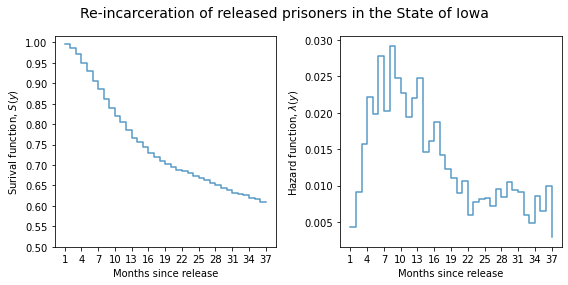

In [12]:
# Define figure object with two subplots
fig_survival, sbp = plt.subplots(ncols=2, figsize=(8, 4))
ax0 = sbp[0] # Handle for left subplot
ax1 = sbp[1] # Handle for right subplot
fig_survival.suptitle('Re-incarceration of released prisoners in the State of Iowa', fontsize=14)

color = '#3B7EA1'                                                                        # Founder's Rock

# Survival function
ax0.set_xlabel(r'Months since release')
ax0.set_ylabel(r'Surival function, $S(y)$')
s = ax0.step(lifetable['Z'], lifetable['$S(y)$'], alpha = 0.75, where = 'post')

ax0.tick_params(axis='y')
ax0.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])
ax0.set_yticks([1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50])
ax0.set_yticklabels(['1.00', '0.95', '0.90', '0.85', '0.80', '0.75', '0.70', '0.65', '0.60', '0.55', '0.50'])

# Hazard function
ax1.set_xlabel(r'Months since release')
ax1.set_ylabel(r'Hazard function, $\lambda(y)$')
s = ax1.step(lifetable['Z'], lifetable['$\lambda(y)$'], alpha = 0.75, where = 'post')

ax1.tick_params(axis='y')
ax1.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])



fig_survival.tight_layout()  
plt.savefig(graphics + 'fig_survival', bbox_inches='tight', dpi=500) 

**Question 4:** Provide a narrative description of both graphs above. At what point is the hazard of re-incarceration greatest? Describe the shape of the hazard function. Discuss possible implications for prisoner re-entry policy. Please place your answer in this markdown box.

**Question 5:** Construct a pointwise 95 percent confidence interval for the Kaplan-Meier estimation of the survival function (as discussed in lecture). Add the confidence interval to the survival function plot above.

**Question 6:** Repeat your analysis for the subsamples of individuals with a **Risk Ranking** of (i)'Low' or 'Moderate and (ii) 'High'. How does the risk of re-incarceration vary across these two groups? Plot the two estimated survival curves on the same graph and provide a narrative description of the graph in a markdown box below it.

## Discrete hazard regression analysis

This next block of code constructs a "person-period" dataset so that we can use logistic regression methods to fit a discrete time hazard model as described in class.    

In [32]:
records = sample[['Z','D','Risk Ranking']].to_dict("records")

person_period = []

for unit in records:
    for t in range(1,(unit['Z']+1)):
        unit_t = unit.copy()
        unit_t['t'] = t
        unit_t['exit'] = (t == unit_t['Z']) and (unit_t['D'] == 1)
        person_period.append(unit_t)
        
ppdf = pd.DataFrame(person_period)
ppdf.rename(columns={'Risk Ranking': 'risk'}, inplace = True)
ppdf[0:15]

,Z,D,risk,t,exit
0,37,False,Low,1,False
1,37,False,Low,2,False
2,37,False,Low,3,False
3,37,False,Low,4,False
4,37,False,Low,5,False
5,37,False,Low,6,False
6,37,False,Low,7,False
7,37,False,Low,8,False
8,37,False,Low,9,False
9,37,False,Low,10,False


**Question 7:** Describe how to construct the period period dataset in words. How does the code block above accomplish this? Please write your answer in this markdown box. Add comments to the code block above.

Next we use statmodels to fit a discrete time hazard model to explore the effects of the risk rating on the hazard of reincarceration. We will leave the baseline hazard fully flexible.

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

result = smf.glm(formula = "exit ~ C(t) + C(risk)", 
                 data=ppdf,
                 family=sm.families.Binomial()).fit()
print(result.summary())

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['exit[False]', 'exit[True]']   No. Observations:               107903
Model:                                       GLM   Df Residuals:                   107864
Model Family:                           Binomial   Df Model:                           38
Link Function:                             logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -7833.0
Date:                           Fri, 20 Jan 2023   Deviance:                       15666.
Time:                                   12:10:02   Pearson chi2:                 1.08e+05
No. Iterations:                                9                                         
Covariance Type:                       nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------

**Question 8:** Interpret the coefficients on the "low" and "moderate" risk ratings? Please write your answer in this markdown box. 

**Question 9:** Fit a model where the baseline hazard is restricted to lie on fourth order polynomial. How do your results compare to those with fully flexible baseline hazard. Please write your answer in this markdown box. 

**Question 10:** What other types of analyses would you be interested in conducting. What additional types of data do you think it would be useful for the State of Iowa to collect? Please write your answer in this markdown box.